In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from PIL import Image
import os
import warnings
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        ,
    'id'          ,
    'csId',
    'csTrainId',
    'level4id',
    'level3id',
    'category',
    'level2id',
    'level1Id',
    'hasInstances',
    'ingnoreInEval',
    'color',
    ] )
labels = [
    #       name                     id    csId     csTrainId level4id        level3Id  category           level2Id      level1Id  hasInstances   ignoreInEval   color
    Label(  'road'                 ,  0   ,  7 ,     0 ,       0   ,     0  ,   'drivable'            , 0           , 0      , False        , False        , (128, 64,128)  ),
    Label(  'parking'              ,  1   ,  9 ,   255 ,       1   ,     1  ,   'drivable'            , 1           , 0      , False        , False         , (250,170,160)  ),
    Label(  'drivable fallback'    ,  2   ,  255 ,   255 ,     2   ,       1  ,   'drivable'            , 1           , 0      , False        , False         , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,  3   ,  8 ,     1 ,       3   ,     2  ,   'non-drivable'        , 2           , 1      , False        , False        , (244, 35,232)  ),
    Label(  'rail track'           ,  4   , 10 ,   255 ,       3   ,     3  ,   'non-drivable'        , 3           , 1      , False        , False         , (230,150,140)  ),
    Label(  'non-drivable fallback',  5   , 255 ,     9 ,      4   ,      3  ,   'non-drivable'        , 3           , 1      , False        , False        , (152,251,152)  ),
    Label(  'person'               ,  6   , 24 ,    11 ,       5   ,     4  ,   'living-thing'        , 4           , 2      , True         , False        , (220, 20, 60)  ),
    Label(  'animal'               ,  7   , 255 ,   255 ,      6   ,      4  ,   'living-thing'        , 4           , 2      , True         , True        , (246, 198, 145)),
    Label(  'rider'                ,  8   , 25 ,    12 ,       7   ,     5  ,   'living-thing'        , 5           , 2      , True         , False        , (255,  0,  0)  ),
    Label(  'motorcycle'           ,  9   , 32 ,    17 ,       8   ,     6  ,   '2-wheeler'           , 6           , 3      , True         , False        , (  0,  0,230)  ),
    Label(  'bicycle'              , 10   , 33 ,    18 ,       9   ,     7  ,   '2-wheeler'           , 6           , 3      , True         , False        , (119, 11, 32)  ),
    Label(  'autorickshaw'         , 11   , 255 ,   255 ,     10   ,      8  ,   'autorickshaw'        , 7           , 3      , True         , False        , (255, 204, 54) ),
    Label(  'car'                  , 12   , 26 ,    13 ,      11   ,     9  ,   'car'                 , 7           , 3      , True         , False        , (  0,  0,142)  ),
    Label(  'truck'                , 13   , 27 ,    14 ,      12   ,     10 ,   'large-vehicle'       , 8           , 3      , True         , False        , (  0,  0, 70)  ),
    Label(  'bus'                  , 14   , 28 ,    15 ,      13   ,     11 ,   'large-vehicle'       , 8           , 3      , True         , False        , (  0, 60,100)  ),
    Label(  'caravan'              , 15   , 29 ,   255 ,      14   ,     12 ,   'large-vehicle'       , 8           , 3      , True         , True         , (  0,  0, 90)  ),
    Label(  'trailer'              , 16   , 30 ,   255 ,      15   ,     12 ,   'large-vehicle'       , 8           , 3      , True         , True         , (  0,  0,110)  ),
    Label(  'train'                , 17   , 31 ,    16 ,      15   ,     12 ,   'large-vehicle'       , 8           , 3      , True         , True        , (  0, 80,100)  ),
    Label(  'vehicle fallback'     , 18   , 355 ,   255 ,     15   ,      12 ,   'large-vehicle'       , 8           , 3      , True         , False        , (136, 143, 153)),  
    Label(  'curb'                 , 19   ,255 ,   255 ,      16   ,     13 ,   'barrier'             , 9           , 4      , False        , False        , (220, 190, 40)),
    Label(  'wall'                 , 20   , 12 ,     3 ,      17   ,     14 ,   'barrier'             , 9           , 4      , False        , False        , (102,102,156)  ),
    Label(  'fence'                , 21   , 13 ,     4 ,      18   ,     15 ,   'barrier'             , 10           , 4      , False        , False        , (190,153,153)  ),
    Label(  'guard rail'           , 22   , 14 ,   255 ,      19   ,     16 ,   'barrier'             , 10          , 4      , False        , False         , (180,165,180)  ),
    Label(  'billboard'            , 23   , 255 ,   255 ,     20   ,      17 ,   'structures'          , 11           , 4      , False        , False        , (174, 64, 67) ),
    Label(  'traffic sign'         , 24   , 20 ,     7 ,      21   ,     18 ,   'structures'          , 11          , 4      , False        , False        , (220,220,  0)  ),
    Label(  'traffic light'        , 25   , 19 ,     6 ,      22   ,     19 ,   'structures'          , 11          , 4      , False        , False        , (250,170, 30)  ),
    Label(  'pole'                 , 26   , 17 ,     5 ,      23   ,     20 ,   'structures'          , 12          , 4      , False        , False        , (153,153,153)  ),
    Label(  'polegroup'            , 27   , 18 ,   255 ,      23   ,     20 ,   'structures'          , 12          , 4      , False        , False         , (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 28   , 255 ,   255 ,     24   ,      21 ,   'structures'          , 12          , 4      , False        , False        , (169, 187, 214) ),  
    Label(  'building'             , 29   , 11 ,     2 ,      25   ,     22 ,   'construction'        , 13          , 5      , False        , False        , ( 70, 70, 70)  ),
    Label(  'bridge'               , 30   , 15 ,   255 ,      26   ,     23 ,   'construction'        , 13          , 5      , False        , False         , (150,100,100)  ),
    Label(  'tunnel'               , 31   , 16 ,   255 ,      26   ,     23 ,   'construction'        , 13          , 5      , False        , False         , (150,120, 90)  ),
    Label(  'vegetation'           , 32   , 21 ,     8 ,      27   ,     24 ,   'vegetation'          , 14          , 5      , False        , False        , (107,142, 35)  ),
    Label(  'sky'                  , 33   , 23 ,    10 ,      28   ,     25 ,   'sky'                 , 15          , 6      , False        , False        , ( 70,130,180)  ),
    Label(  'fallback background'  , 34   , 255 ,   255 ,     29   ,      25 ,   'object fallback'     , 15          , 6      , False        , False        , (169, 187, 214)),
    Label(  'unlabeled'            , 35   ,  0  ,     255 ,   255   ,      255 ,   'void'                , 255         , 255    , False        , True         , (  0,  0,  0)  ),
    Label(  'ego vehicle'          , 36   ,  1  ,     255 ,   255   ,      255 ,   'void'                , 255         , 255    , False        , True         , (  0,  0,  0)  ),
    Label(  'rectification border' , 37   ,  2  ,     255 ,   255   ,      255 ,   'void'                , 255         , 255    , False        , True         , (  0,  0,  0)  ),
    Label(  'out of roi'           , 38   ,  3  ,     255 ,   255   ,      255 ,   'void'                , 255         , 255    , False        , True         , (  0,  0,  0)  ),
    Label(  'license plate'        , 39   , 255 ,     255 ,   255   ,      255 ,   'vehicle'             , 255         , 255    , False        , True         , (  0,  0,142)  ),
    
]  

In [3]:
N_FILTERS = 64
KERNEL_SIZE = 3
N_CLASSES = len(labels)
IMAGE_SIZE = [128,128]
IMAGE_SHAPE = IMAGE_SIZE + [3,]
EPOCHS = 2
BATCH_SIZE = 16
MODEL_CHECKPOINT_FILEPATH = '/kaggle/working/imagesegmented-unet.weights.h5'

id2color = { label.id : np.asarray(label.color) for label in labels }


In [4]:
def closest_labels(mask, mapping):
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): 
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category

In [5]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def load_images(train_root_filepath, mask_root_filepath, image_size=(128, 128)):
    train_images = []
    train_masks = []
    train_masks_enc = []
    for subdir in tqdm(os.listdir(train_root_filepath), desc='Loading images from subdirectories'):
        subdir_path = os.path.join(train_root_filepath, subdir)
        if os.path.isdir(subdir_path):  
            for train_file in os.listdir(subdir_path):
                if train_file.endswith('_leftImg8bit.jpg'):
                    train_image_path = os.path.join(subdir_path, train_file)
                    train_image = Image.open(train_image_path).convert('RGB').resize(image_size)
                    train_images.append(np.array(train_image) / 255.0)
                    mask_file = train_file.replace('_leftImg8bit.jpg', '_gtFine_labelColors.png')
                    mask_image_path = os.path.join(mask_root_filepath, subdir, mask_file)

                    if os.path.exists(mask_image_path):
                        mask_image = Image.open(mask_image_path).convert('RGB').resize(image_size)
                        mask_array = np.array(mask_image)

                        mask_enc = closest_labels(mask_array, id2color)
                        
                        train_masks.append(mask_array)
                        train_masks_enc.append(mask_enc)
                    else:
                        print(f"Warning: Mask file {mask_file} not found in {mask_root_filepath}")

    return train_images, train_masks, train_masks_enc

train_filepath = '/kaggle/input/iitg-ai-overnight-hackathon-2024/dataset/dataset/train'  
mask_filepath = '/kaggle/input/iitg-ai-overnight-hackathon-2024/dataset/dataset/labels' 

train_images, train_masks, train_masks_enc = load_images(train_filepath, mask_filepath)


Loading images from subdirectories: 100%|██████████| 249/249 [21:28<00:00,  5.17s/it]


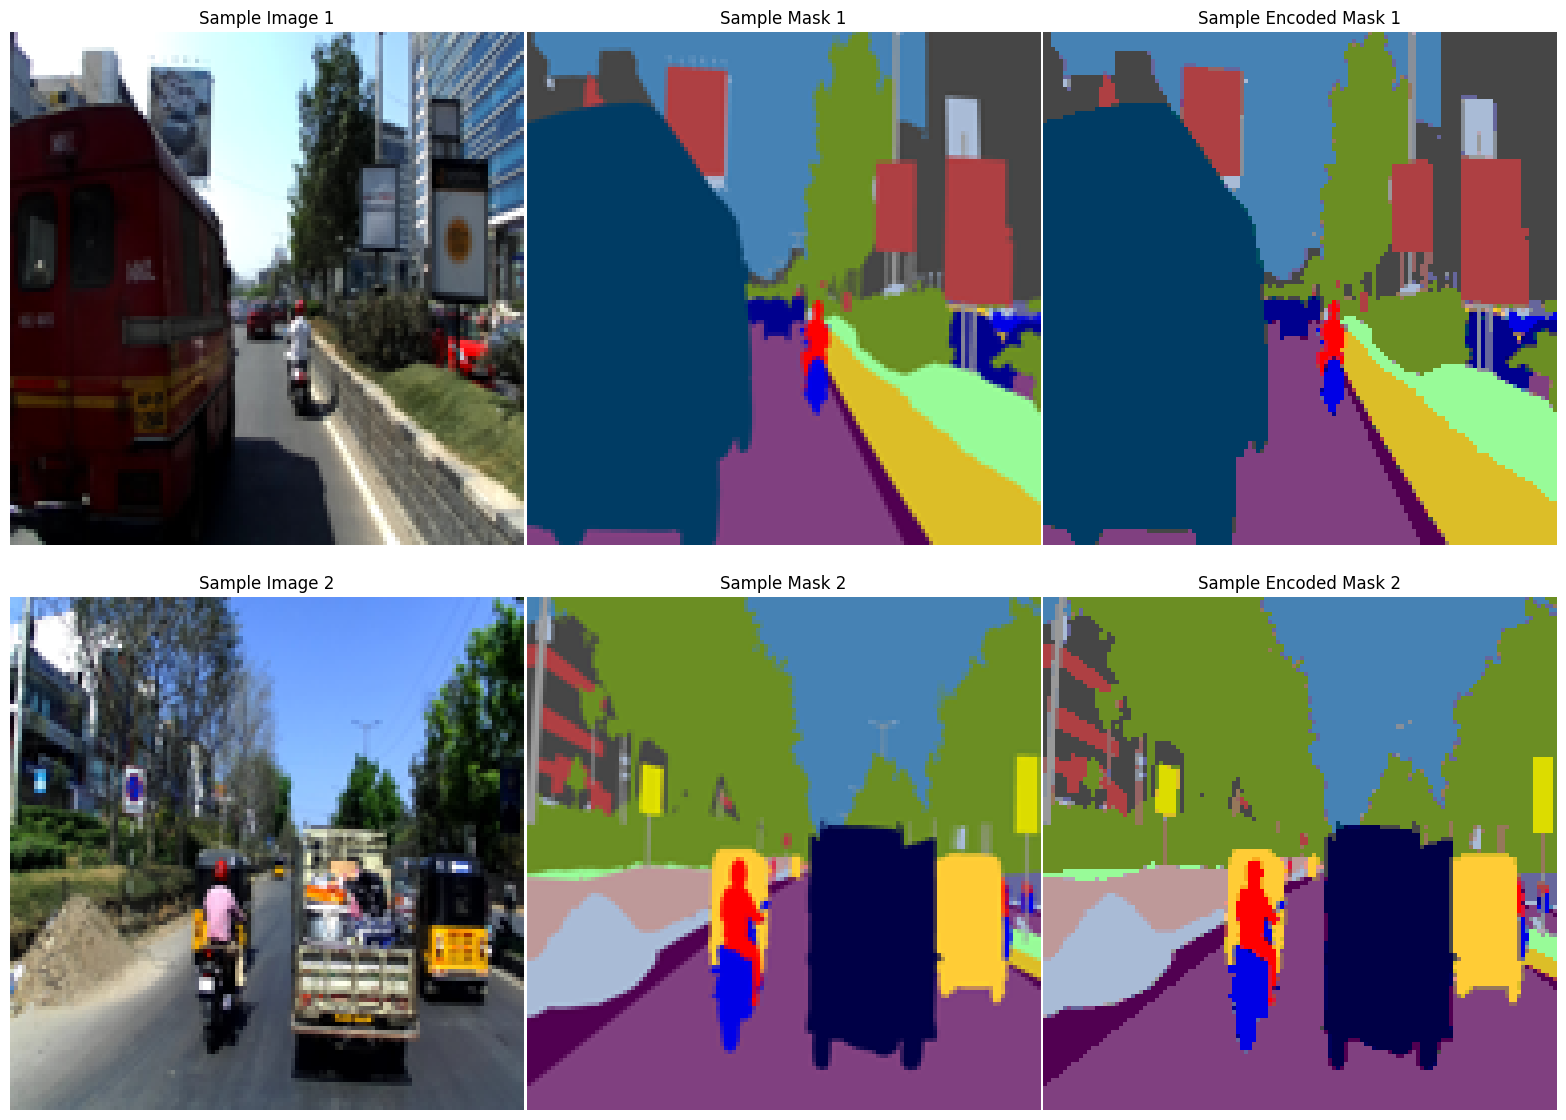

In [6]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
            
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [7]:
train_images=np.stack(train_images).astype('float32')
train_masks_enc=np.stack(train_masks_enc).astype('float32')

In [8]:
print(train_masks_enc.shape)

(7034, 128, 128)


In [9]:
print(f"Train Images Shape: {len(train_images)}, Shape: {(train_images[0].shape)}")
print(f"Train Masks Shape: {len(train_masks)}, Shape: {(train_masks[0].shape)}")
print(f"Train Masks Encoded Shape: {len(train_masks_enc)}, Shape: {(train_masks_enc[0].shape)}")


Train Images Shape: 7034, Shape: (128, 128, 3)
Train Masks Shape: 7034, Shape: (128, 128, 3)
Train Masks Encoded Shape: 7034, Shape: (128, 128)


In [10]:
def conv_block(inputs=None, n_filters=32, kernel_size = 3, dropout_prob = 0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3,  
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection



In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, kernel_size = 3):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = kernel_size,   
                 strides = (2,2),
                 padding = 'same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,  
                 kernel_size = (3,3),  
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 
                 kernel_size = (3,3), 
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [12]:
def create_unet_model(image_shape, n_filters, kernel_size, n_classes):

    inputs = Input(image_shape)

    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters, kernel_size)
    cblock2 = conv_block(cblock1[0], n_filters * 2, kernel_size)
    cblock3 = conv_block(cblock2[0], n_filters * 4, kernel_size, dropout_prob = 0.3)
    cblock4 = conv_block(cblock3[0], n_filters * 8, kernel_size, dropout_prob = 0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, kernel_size, dropout_prob = 0.3, max_pooling=False) 


    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8, kernel_size)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4, kernel_size)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2, kernel_size)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters, kernel_size)

    conv9 = Conv2D(n_filters,
                 kernel_size = kernel_size,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, kernel_size = 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

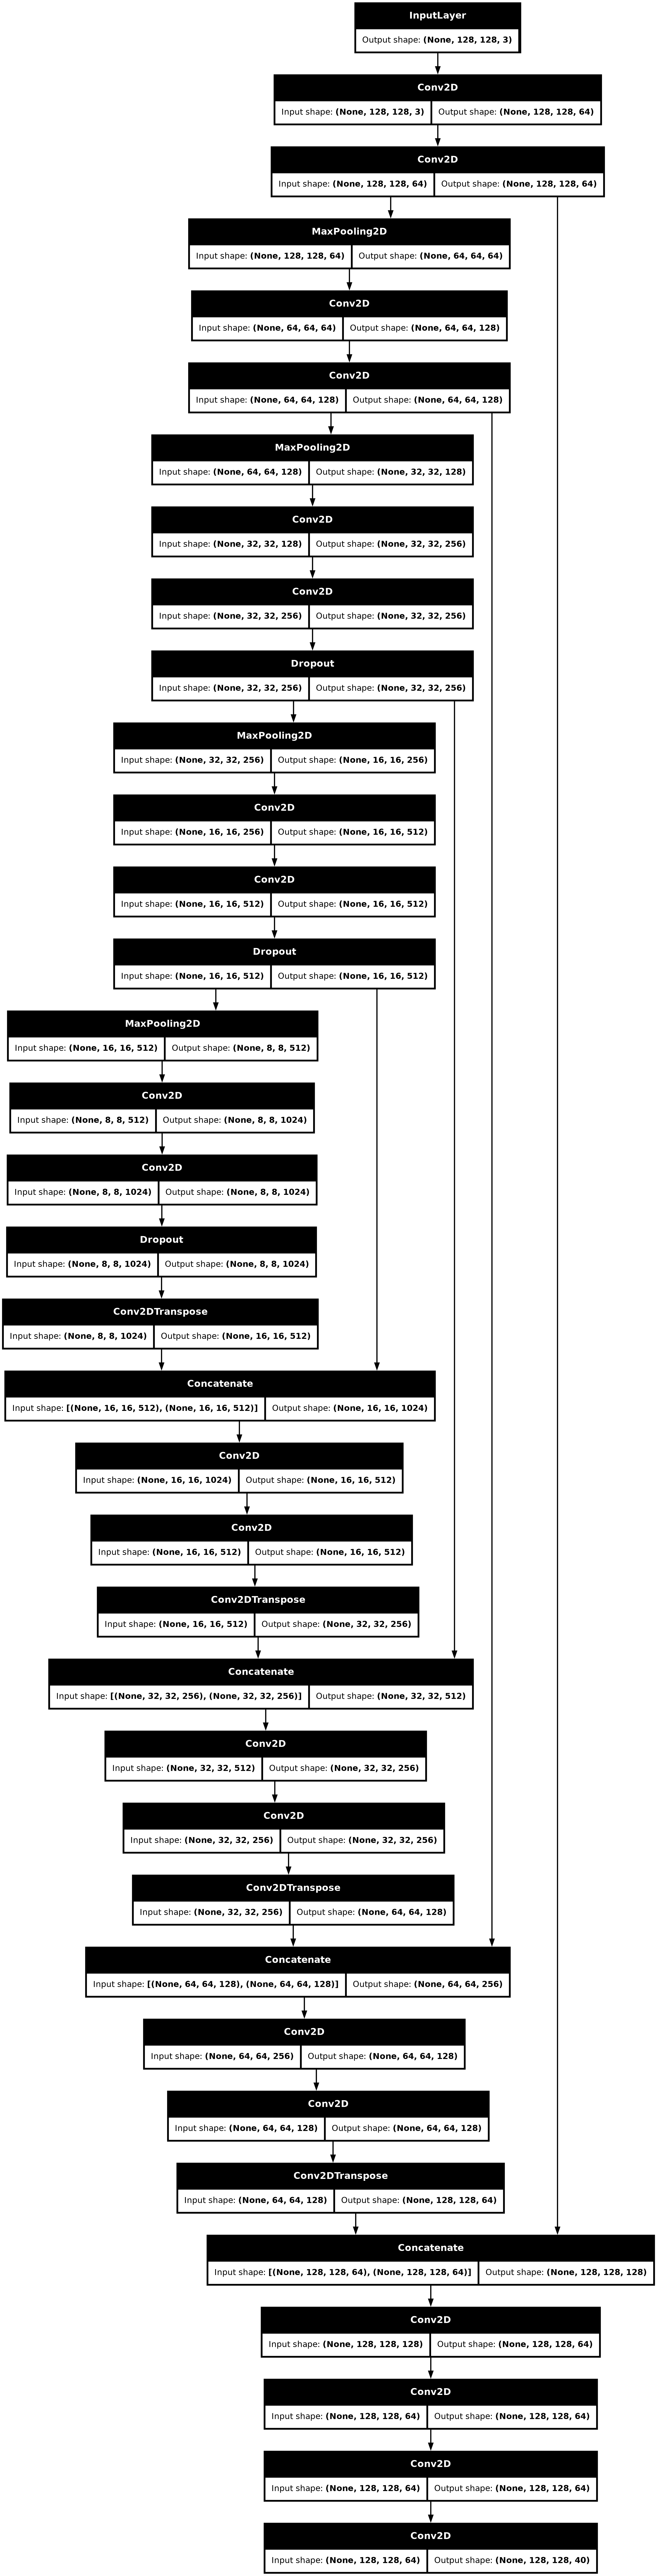

In [13]:

model = create_unet_model(IMAGE_SHAPE, N_FILTERS, KERNEL_SIZE, N_CLASSES)

tf.keras.utils.plot_model(model, show_shapes = True)

In [14]:
train_size = int(0.8 * len(train_images)) 
x_train, x_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_masks_enc[:train_size], train_masks_enc[train_size:]

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define the model checkpoint
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode='max',
                                  save_freq=1)

callbacks = [model_checkpoint]


history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks)


Epoch 1/2
  1/352 ━━━━━━━━━━━━━━━━━━━━ 2:04:33 21s/step - accuracy: 0.0038 - loss: 3.7241

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:199: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 4757s 13s/step - accuracy: 0.5074 - loss: 1.9990 - val_accuracy: 0.6824 - val_loss: 1.1346
Epoch 2/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 4756s 13s/step - accuracy: 0.6973 - loss: 1.0465 - val_accuracy: 0.7097 - val_loss: 1.0143


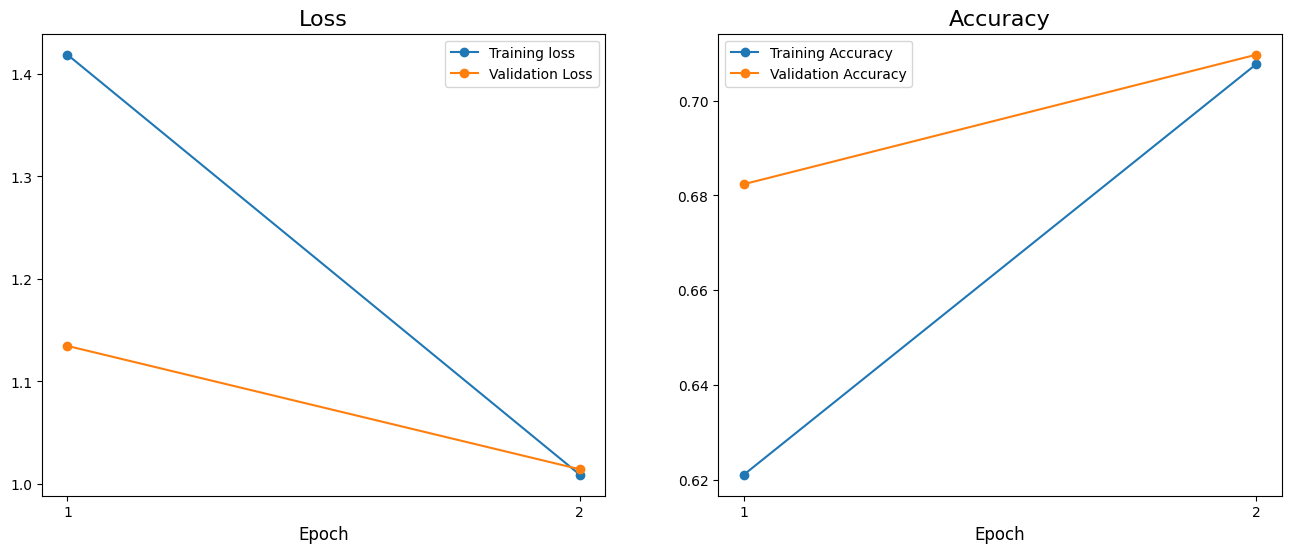

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


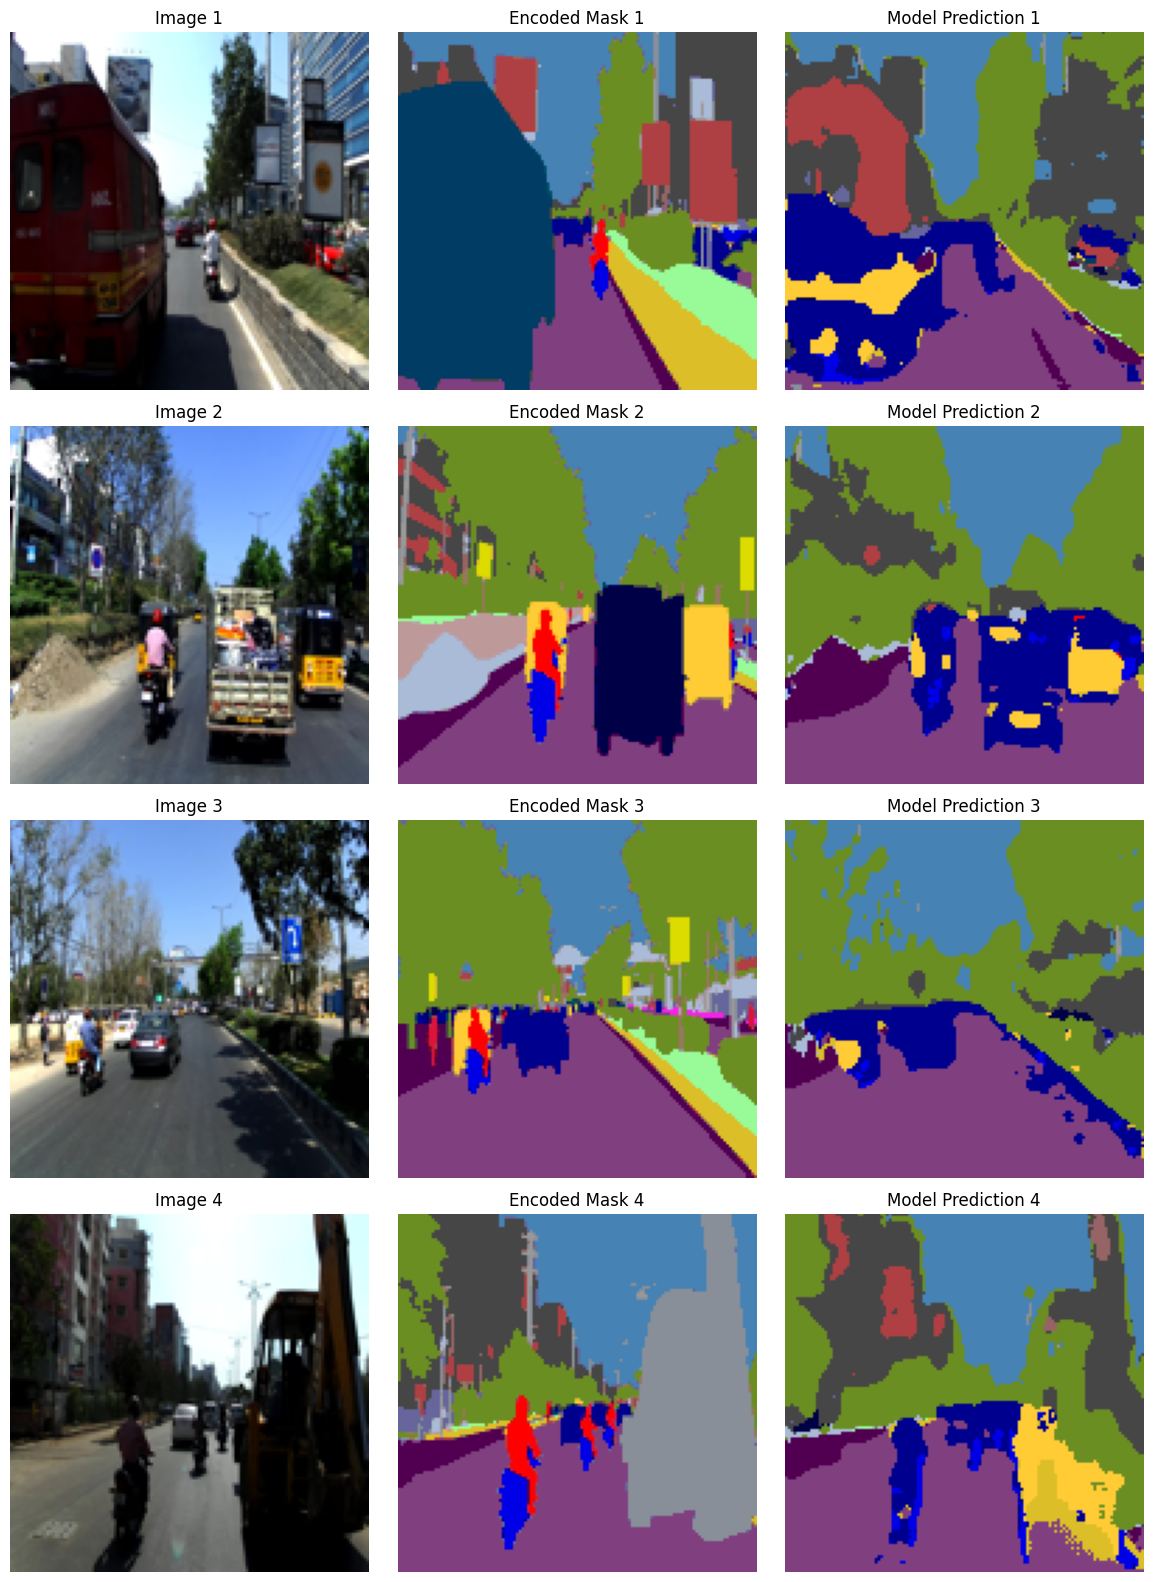

In [17]:
plt.figure(figsize=[15, 20])

for i in range(4):    
    img = train_images[i]
    enc = train_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

Loading Test Images: 100%|██████████| 118/118 [00:05<00:00, 21.43it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


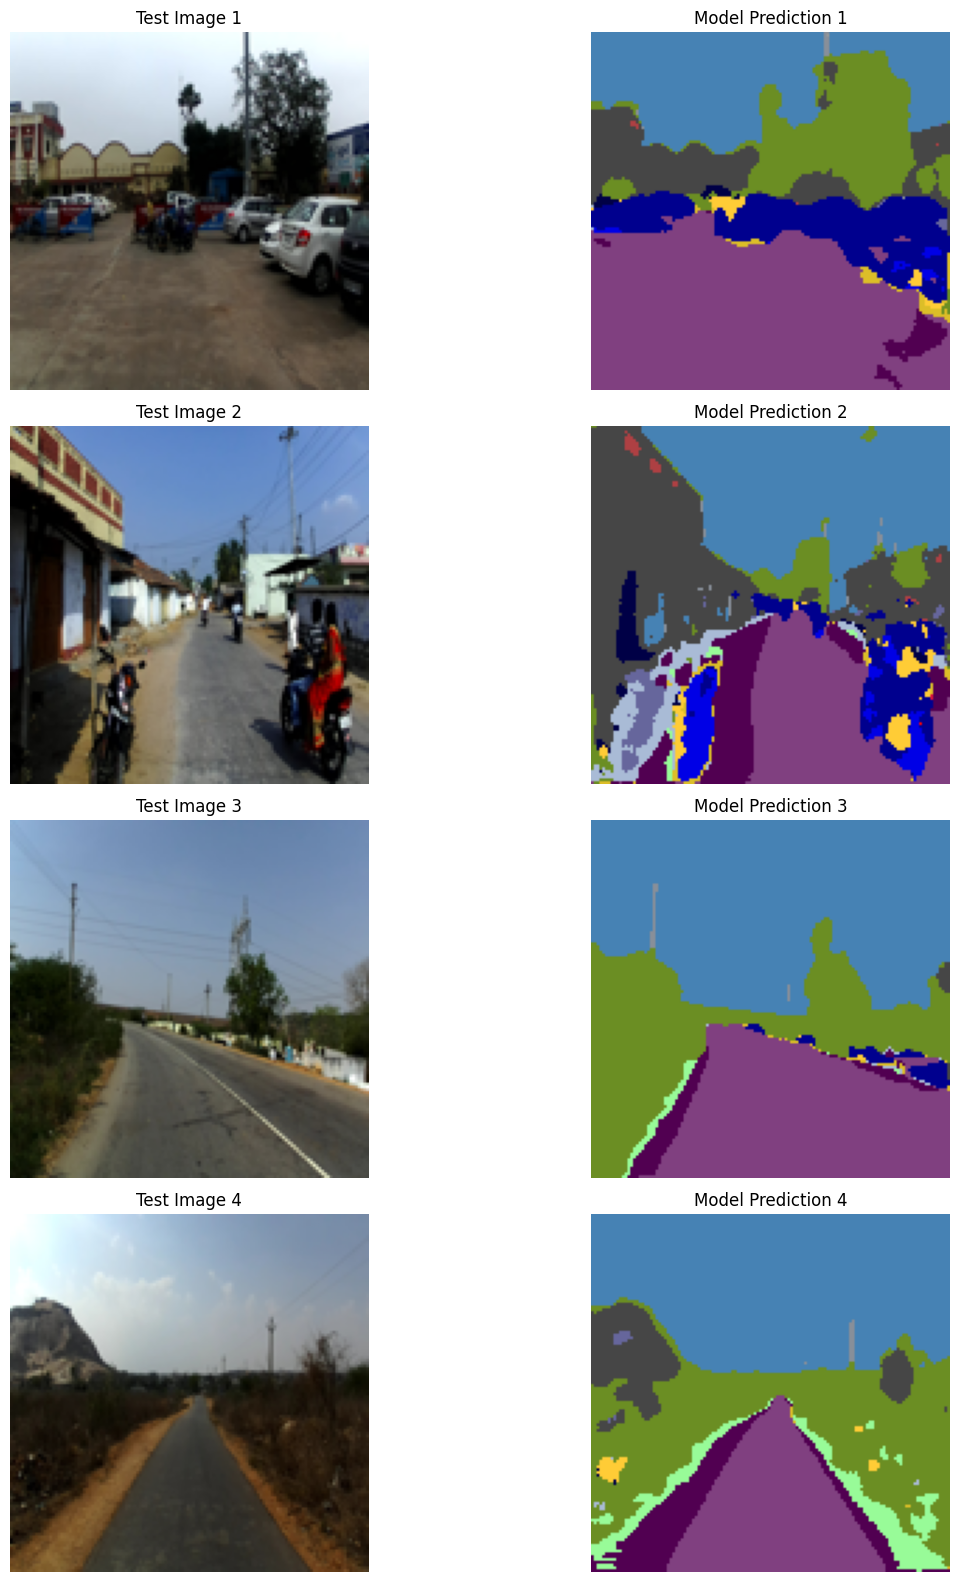

In [18]:

def load_test_images(test_filepath, image_size=(128,128)):
    test_images = []

    for test_file in tqdm(os.listdir(test_filepath), desc='Loading Test Images: '):
        if test_file.endswith('_leftImg8bit.jpg'): 
            test_image_path = os.path.join(test_filepath, test_file)
            test_image = Image.open(test_image_path).convert('RGB').resize(image_size)
            test_images.append(np.array(test_image) / 255.0) 
    return test_images

def visualize_predictions(test_images, model, id2color, IMAGE_SHAPE):
    plt.figure(figsize=[15, 20])

    for i in range(min(4, len(test_images))):  
        img = test_images[i] 
        

        pred = model.predict(img.reshape([1] + list(IMAGE_SHAPE))) 
        pred = np.squeeze(np.argmax(pred, axis=-1))
        
        tmp2 = np.zeros([pred.shape[0], pred.shape[1], 3])

        for row in range(pred.shape[0]):
            for col in range(pred.shape[1]):
                tmp2[row, col, :] = id2color[pred[row, col]] 
        tmp2 = tmp2.astype('uint8')

        plt.subplot(4, 2, i*2 + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.gca().set_title('Test Image {}'.format(str(i+1)))

        plt.subplot(4, 2, i*2 + 2)
        plt.imshow(tmp2)
        plt.axis('off')
        plt.gca().set_title('Model Prediction {}'.format(str(i+1)))

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

test_filepath = '/kaggle/input/iitg-ai-overnight-hackathon-2024/dataset/dataset/test' 
IMAGE_SHAPE = (128,128, 3)

test_images = load_test_images(test_filepath)

visualize_predictions(test_images, model, id2color, IMAGE_SHAPE)


In [19]:

def get_predicted_masks(test_images, model, IMAGE_SHAPE):
    predicted_masks = [] 
    for img in tqdm(test_images, desc='Predicting Masks: '):

        pred = model.predict(img.reshape([1] + list(IMAGE_SHAPE))) 
        pred = np.squeeze(np.argmax(pred, axis=-1)) 

        predicted_masks.append(pred)

    return predicted_masks 

predicted_masks = get_predicted_masks(test_images, model, IMAGE_SHAPE)


Predicting Masks:   0%|          | 0/118 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:   1%|          | 1/118 [00:00<00:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:   2%|▏         | 2/118 [00:00<00:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:   3%|▎         | 3/118 [00:00<00:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:   3%|▎         | 4/118 [00:01<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:   4%|▍         | 5/118 [00:01<00:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:   5%|▌         | 6/118 [00:01<00:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:   6%|▌         | 7/118 [00:01<00:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:   7%|▋         | 8/118 [00:02<00:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:   8%|▊         | 9/118 [00:02<00:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:   8%|▊         | 10/118 [00:02<00:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:   9%|▉         | 11/118 [00:03<00:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  10%|█         | 12/118 [00:03<00:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  11%|█         | 13/118 [00:03<00:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  12%|█▏        | 14/118 [00:03<00:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  13%|█▎        | 15/118 [00:04<00:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Predicting Masks:  14%|█▎        | 16/118 [00:04<00:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  14%|█▍        | 17/118 [00:04<00:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  15%|█▌        | 18/118 [00:05<00:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  16%|█▌        | 19/118 [00:05<00:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  17%|█▋        | 20/118 [00:05<00:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  18%|█▊        | 21/118 [00:06<00:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  19%|█▊        | 22/118 [00:06<00:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  19%|█▉        | 23/118 [00:06<00:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Predicting Masks:  20%|██        | 24/118 [00:06<00:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  21%|██        | 25/118 [00:07<00:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  22%|██▏       | 26/118 [00:07<00:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  23%|██▎       | 27/118 [00:07<00:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  24%|██▎       | 28/118 [00:08<00:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  25%|██▍       | 29/118 [00:08<00:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  25%|██▌       | 30/118 [00:08<00:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  26%|██▋       | 31/118 [00:08<00:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  27%|██▋       | 32/118 [00:09<00:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  28%|██▊       | 33/118 [00:09<00:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  29%|██▉       | 34/118 [00:09<00:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  30%|██▉       | 35/118 [00:10<00:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Predicting Masks:  31%|███       | 36/118 [00:10<00:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  31%|███▏      | 37/118 [00:10<00:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  32%|███▏      | 38/118 [00:10<00:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  33%|███▎      | 39/118 [00:11<00:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  34%|███▍      | 40/118 [00:11<00:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Predicting Masks:  35%|███▍      | 41/118 [00:11<00:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  36%|███▌      | 42/118 [00:12<00:21,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Predicting Masks:  36%|███▋      | 43/118 [00:12<00:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  37%|███▋      | 44/118 [00:12<00:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  38%|███▊      | 45/118 [00:12<00:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  39%|███▉      | 46/118 [00:13<00:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  40%|███▉      | 47/118 [00:13<00:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  41%|████      | 48/118 [00:13<00:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  42%|████▏     | 49/118 [00:14<00:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  42%|████▏     | 50/118 [00:14<00:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  43%|████▎     | 51/118 [00:14<00:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Predicting Masks:  44%|████▍     | 52/118 [00:14<00:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  45%|████▍     | 53/118 [00:15<00:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  46%|████▌     | 54/118 [00:15<00:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  47%|████▋     | 55/118 [00:15<00:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  47%|████▋     | 56/118 [00:16<00:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  48%|████▊     | 57/118 [00:16<00:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Predicting Masks:  49%|████▉     | 58/118 [00:16<00:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Predicting Masks:  50%|█████     | 59/118 [00:16<00:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  51%|█████     | 60/118 [00:17<00:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  52%|█████▏    | 61/118 [00:17<00:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  53%|█████▎    | 62/118 [00:17<00:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  53%|█████▎    | 63/118 [00:18<00:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  54%|█████▍    | 64/118 [00:18<00:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  55%|█████▌    | 65/118 [00:18<00:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  56%|█████▌    | 66/118 [00:18<00:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  57%|█████▋    | 67/118 [00:19<00:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  58%|█████▊    | 68/118 [00:19<00:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  58%|█████▊    | 69/118 [00:19<00:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  59%|█████▉    | 70/118 [00:20<00:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  60%|██████    | 71/118 [00:20<00:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  61%|██████    | 72/118 [00:20<00:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  62%|██████▏   | 73/118 [00:20<00:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  63%|██████▎   | 74/118 [00:21<00:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Predicting Masks:  64%|██████▎   | 75/118 [00:21<00:13,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Predicting Masks:  64%|██████▍   | 76/118 [00:21<00:13,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Predicting Masks:  65%|██████▌   | 77/118 [00:22<00:13,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Predicting Masks:  66%|██████▌   | 78/118 [00:22<00:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Predicting Masks:  67%|██████▋   | 79/118 [00:23<00:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Predicting Masks:  68%|██████▊   | 80/118 [00:23<00:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  69%|██████▊   | 81/118 [00:23<00:12,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  69%|██████▉   | 82/118 [00:23<00:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  70%|███████   | 83/118 [00:24<00:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  71%|███████   | 84/118 [00:24<00:10,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  72%|███████▏  | 85/118 [00:24<00:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  73%|███████▎  | 86/118 [00:25<00:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  74%|███████▎  | 87/118 [00:25<00:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  75%|███████▍  | 88/118 [00:25<00:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  75%|███████▌  | 89/118 [00:25<00:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  76%|███████▋  | 90/118 [00:26<00:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  77%|███████▋  | 91/118 [00:26<00:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Predicting Masks:  78%|███████▊  | 92/118 [00:26<00:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  79%|███████▉  | 93/118 [00:27<00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  80%|███████▉  | 94/118 [00:27<00:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  81%|████████  | 95/118 [00:27<00:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  81%|████████▏ | 96/118 [00:27<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  82%|████████▏ | 97/118 [00:28<00:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  83%|████████▎ | 98/118 [00:28<00:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  84%|████████▍ | 99/118 [00:28<00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  85%|████████▍ | 100/118 [00:29<00:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  86%|████████▌ | 101/118 [00:29<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  86%|████████▋ | 102/118 [00:29<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  87%|████████▋ | 103/118 [00:29<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  88%|████████▊ | 104/118 [00:30<00:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Predicting Masks:  89%|████████▉ | 105/118 [00:30<00:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Predicting Masks:  90%|████████▉ | 106/118 [00:30<00:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  91%|█████████ | 107/118 [00:31<00:03,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Predicting Masks:  92%|█████████▏| 108/118 [00:31<00:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  92%|█████████▏| 109/118 [00:31<00:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  93%|█████████▎| 110/118 [00:31<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  94%|█████████▍| 111/118 [00:32<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  95%|█████████▍| 112/118 [00:32<00:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Predicting Masks:  96%|█████████▌| 113/118 [00:32<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  97%|█████████▋| 114/118 [00:33<00:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Predicting Masks:  97%|█████████▋| 115/118 [00:33<00:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Predicting Masks:  98%|█████████▊| 116/118 [00:33<00:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Predicting Masks:  99%|█████████▉| 117/118 [00:33<00:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Predicting Masks: 100%|██████████| 118/118 [00:34<00:00,  3.45it/s]


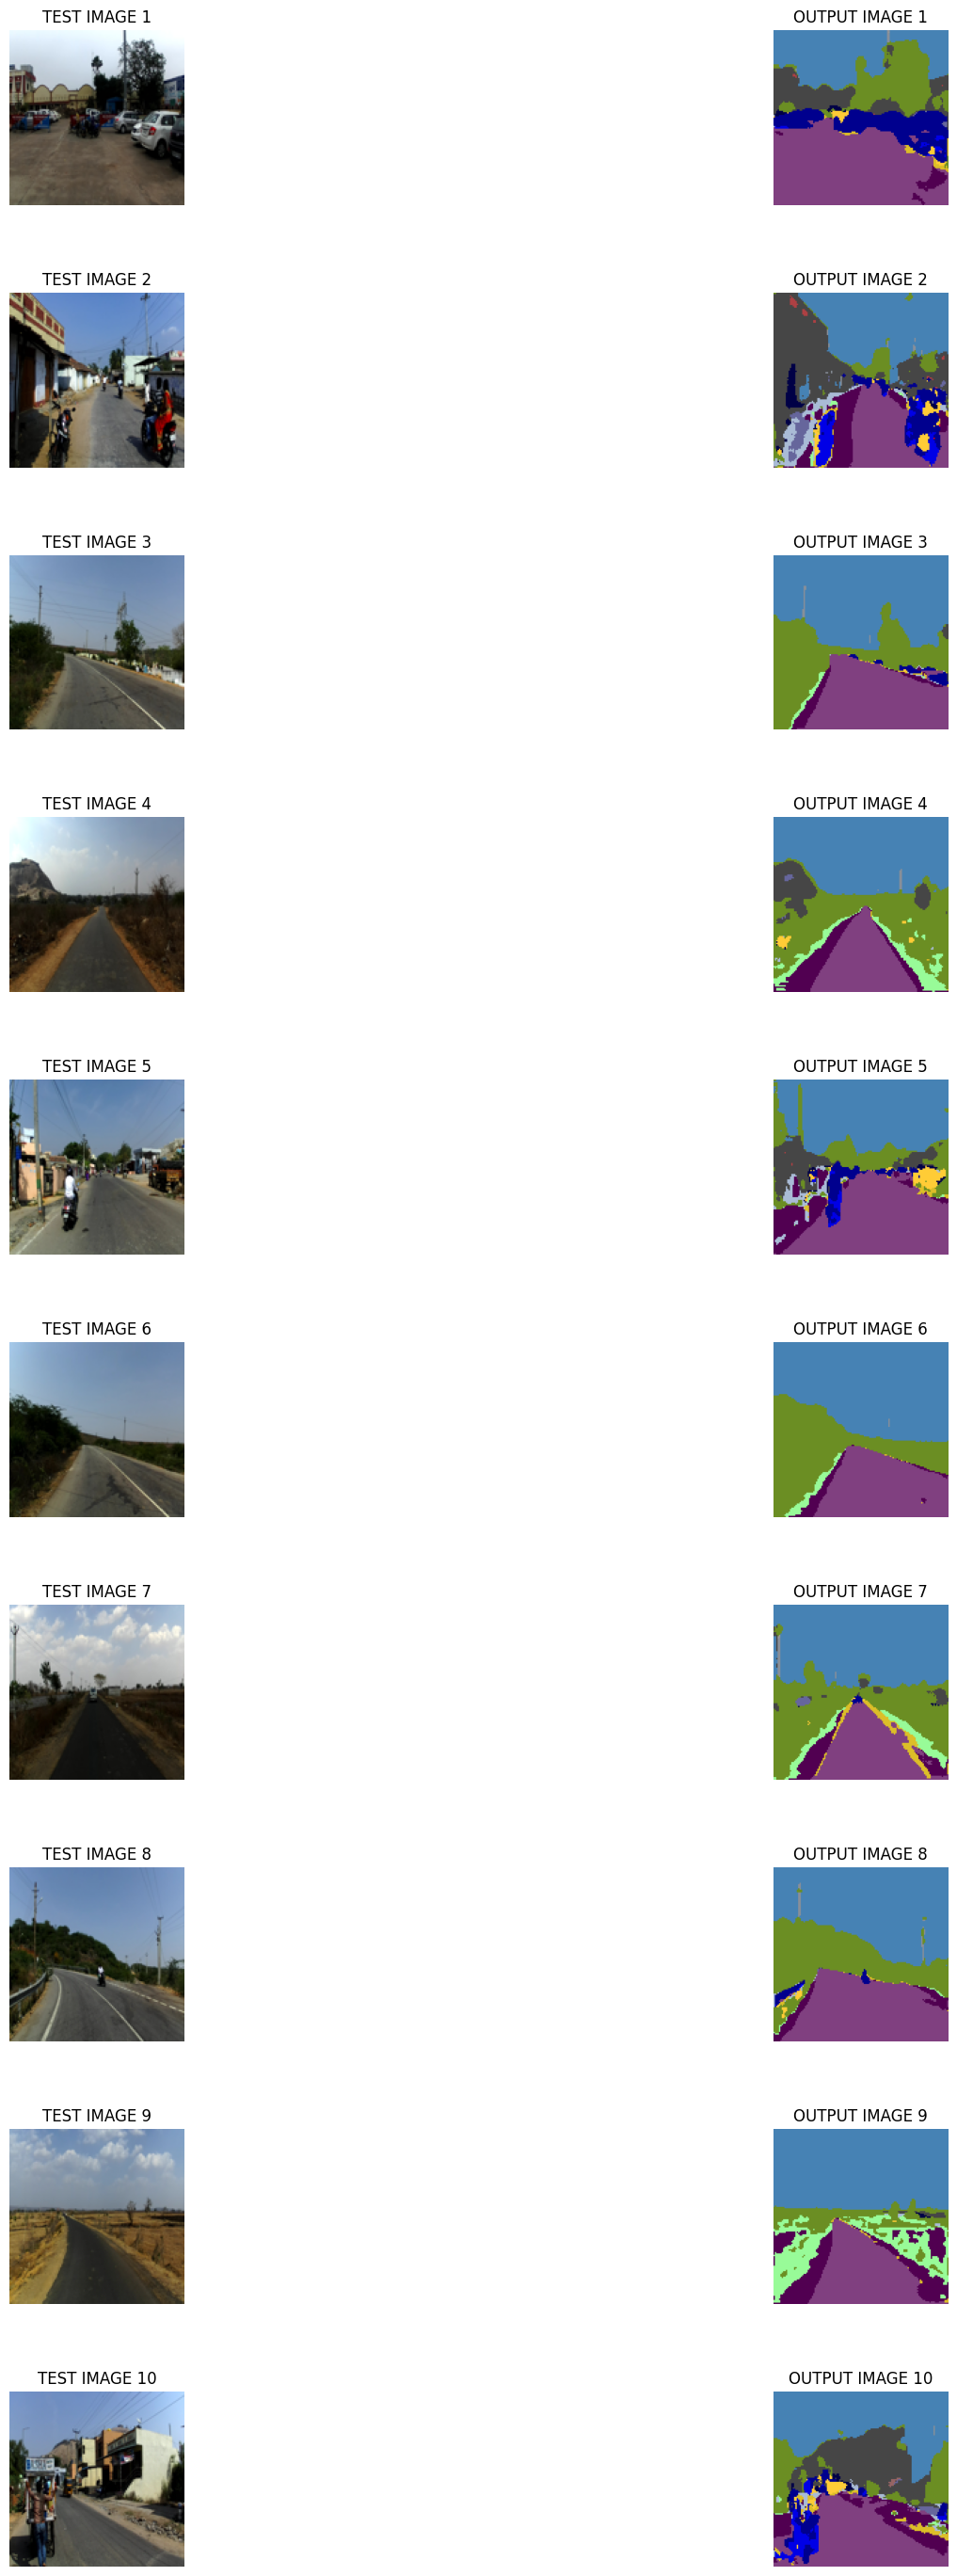

In [20]:
plt.figure(figsize=[20, 35])

for i in range(10):  
    img = test_images[i]
    enc = predicted_masks[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
    tmp = tmp.astype('uint8')
    
    # Show test image
    plt.subplot(10, 2, i*2 + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title(f'TEST IMAGE {i+1}')
    
    # Show corresponding output image
    plt.subplot(10, 2, i*2 + 2) 
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title(f'OUTPUT IMAGE {i+1}')
    
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()


In [21]:
predicted_masks=np.stack(predicted_masks).astype('float32')


In [22]:
print(f"Predicted Maks: {len(predicted_masks)}, Shape: {(predicted_masks[0].shape)}")

Predicted Maks: 118, Shape: (128, 128)


In [23]:
import time

test_image = np.expand_dims(test_images[0], axis=0) 

start_time = time.time()

predicted_mask = model.predict(test_image)

inference_time = time.time() - start_time
print(f"Inference Time: {inference_time:.4f} seconds per image")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Inference Time: 0.2831 seconds per image


In [24]:
import os
model.save('/kaggle/working/imagesegmented-unet.weights.h5')
model_size = os.path.getsize('/kaggle/working/imagesegmented-unet.weights.h5') / (1024 * 1024)
print(f"Model Size: {model_size:.2f} MB")


Model Size: 395.60 MB


In [25]:
val_loss, val_accuracy = model.evaluate(x = x_val, y = y_val) 
print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*val_accuracy, 2)) + '\033[0m')
# Earlier I had achieved an accuracy of more than 80 percent but because I lost my all progress twice , and ran only for 2 epochs , i still got 71 percent accuracy


44/44 ━━━━━━━━━━━━━━━━━━━━ 327s 7s/step - accuracy: 0.6968 - loss: 1.0547

The model had an accuracy score of 70.97%!!
